# Presplit/deterministic enrichment
The formated dataset still has some multi-entry columns (e.g. country). Creating a dummy for every country would lead to 171 extra columns (times the other multi-entry columns). This risks overfitting and a lot of missings. We thus group the countries in advance by their geographical location. Furthermore, SME and organizationID are multi-entry columns too. We create numerical columns to count the number of SMEs and organizations, respectively.

In [1]:
# Libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from sklearn.pipeline     import Pipeline, FeatureUnion
from sklearn.impute       import SimpleImputer
from sklearn.compose          import TransformedTargetRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import openpyxl
from joblib import parallel_backend


In [2]:
df = pd.read_excel("MordernDataAnalytics.xlsx")

# Define geographic groups
geo_groups = {
    'Western_Europe': {'DE', 'FR', 'BE', 'NL', 'LU', 'CH', 'AT', 'LI'},
    'Northern_Europe': {'UK', 'IE', 'SE', 'FI', 'DK', 'IS', 'NO', 'EE', 'LV', 'LT'},
    'Southern_Europe': {'IT', 'ES', 'PT', 'EL', 'MT', 'CY', 'SI'},
    'Eastern_Europe': {'PL', 'CZ', 'SK', 'HU', 'RO', 'BG', 'RS', 'UA', 'AL', 'MK', 'ME', 'XK', 'HR', 'MD', 'GE', 'BA'},
    'Africa': {'ZA', 'KE', 'UG', 'TN', 'GH', 'MA', 'TZ', 'EG', 'SN', 'CD', 'MZ', 'RW', 'BF', 'ZM', 'CI', 'CM', 'ET', 'NG', 'DZ', 'AO', 'GN', 'BJ', 'GA', 'MW', 'ML', 'BI', 'MU', 'ST', 'LR', 'ZW', 'CG', 'GW', 'NE', 'LY', 'GQ', 'SD', 'LS', 'TD', 'DJ'},
    'Asia': {'IL', 'TR', 'IN', 'CN', 'JP', 'KR', 'TH', 'SG', 'LB', 'TW', 'UZ', 'AM', 'VN', 'MY', 'KZ', 'PK', 'AZ', 'HK', 'ID', 'JO', 'BD', 'KG', 'IR', 'PS', 'MN', 'KH', 'TJ', 'IQ', 'TM', 'NP', 'KW', 'QA', 'AF', 'BT', 'MO', 'MV', 'LA', 'LK'},
    'Oceania': {'AU', 'NZ', 'FJ', 'MH', 'PG', 'NC'},
    'Americas': {'US', 'CA', 'BR', 'AR', 'CO', 'CL', 'MX', 'PE', 'UY', 'BO', 'CR', 'PA', 'GT', 'SV', 'PY', 'EC', 'VE', 'DO', 'HT', 'SR', 'AW', 'BQ', 'AI', 'GU'}
}

# Number of partners from geo_groups
for region, countries in geo_groups.items():
    df[f'{region}_count'] = (
        df['country']
          .str.split(';')
          .apply(lambda lst: sum(c.strip() in countries for c in lst))
    )

# Number of countries per project
df['num_countries'] = df['country'].str.split(';').apply(lambda x: len([c.strip() for c in x if c.strip()]))

# Number of organizations per project (later choose only one of the 2 as feature because almost the same)
df['num_organisations'] = df['organisationID'].str.split(';').apply(lambda x: len([o.strip() for o in x if o.strip()]))

# Number of SMEs per project
def count_smes(s):
    entries = [e.strip() for e in s.split(';') if e.strip()]
    return sum(1 for e in entries if e.lower() == 'true')

df['num_sme'] = df['SME'].apply(count_smes)

# Number of different roles per project
df['role_list'] = df['role'].str.split(';').apply(lambda L: [r.strip() for r in L])
df['n_participant'] = df['role_list'].apply(lambda L: L.count('participant'))
df['n_associatedPartner']= df['role_list'].apply(lambda L: L.count('associatedPartner'))
df['n_thirdParty']= df['role_list'].apply(lambda L: L.count('thirdParty'))


We also want to transform the date columns into the more meaningful variables: starting year, starting month and duration, signature lag days.

In [3]:
for col in ['startDate', 'endDate', 'ecSignatureDate']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

df['duration_days']      = (df.endDate - df.startDate).dt.days
df['start_year']         = df.startDate.dt.year
df['start_month']        = df.startDate.dt.month

The EuroSciVoc table has additional information about the topic domain. We want to include that in our data and analysis.

In [4]:
# Load the Euroscivox data
df2 = pd.read_excel("euroSciVoc.xlsx", usecols=['projectID','euroSciVocPath'])

# Extract the first “folder” from the path as topic domain (the thing between the first two slashes)
df2['euroSciVoxTopic'] = df2['euroSciVocPath'].str.extract(r'^/([^/]+)/?')

# Keep one row per projectID
df2 = (
    df2[['projectID','euroSciVoxTopic']]
      .drop_duplicates(subset='projectID')
)

# Left‐merge into main df
df = df.merge(df2, on='projectID', how='left')

df['euroSciVoxTopic'] = df['euroSciVoxTopic'].fillna('not available')

print(df.head())


   projectID        acronym  status  \
0  101159220      PvSeroRDT  SIGNED   
1  101096150       BIOBoost  SIGNED   
2  101093997  GlycanTrigger  SIGNED   
3  101126531   CHIKVAX_CHIM  SIGNED   
4  101113979      The Oater  CLOSED   

                                               title  startDate    endDate  \
0  A point-of-care serological rapid diagnostic t... 2025-02-01 2030-01-31   
1  Boosting innovation agencies for bioeconomy va... 2023-02-01 2025-01-31   
2  GLYCANS AS MASTER TRIGGERS OF HEALTH TO INTEST... 2023-01-01 2028-12-31   
3  Late-stage clinical development of Chikungunya... 2023-06-01 2028-11-30   
4  The Oater develops a compact machine for hyper... 2023-07-01 2023-12-31   

   ecMaxContribution ecSignatureDate                              masterCall  \
0         4062396.23      2024-12-09  HORIZON-JU-GH-EDCTP3-2023-02-two-stage   
1          500000.00      2022-11-25             HORIZON-EIE-2022-CONNECT-01   
2         6771571.00      2022-12-05           HORIZON-H

In [5]:
df.to_csv("df_eu.csv", index=False)

# Feature Enrichment and Model

In [6]:
# 1) train/test split
target = df['ecMaxContribution']
X_train, X_test, y_train, y_test = train_test_split(
    df, target, test_size=0.2, random_state=42
)

We have the organisationID column and also the net_ecContribution_list column. We want to include a feature for each organisation’s “past mean EC” using only contributions from earlier projects (shifting the cumulative sum/count so the current row’s own contribution is excluded). In addition, we need a lookup (org_dim) that the transformer uses at predict time.

In [7]:
# 2) precompute lookup table
# organization lookup
train_long = (
    X_train[['projectID','organisationID','ecContribution_list','startDate']]
    .copy()
)

# normalize delimiters
train_long['clean_orgs'] = (
    train_long['organisationID']
      .astype(str)
      .str.strip('[]')
      .str.replace(r'[;,]', ';', regex=True)
)

train_long['clean_ecs'] = (
    train_long['ecContribution_list']
      .astype(str)
      .str.strip('[]')
      .str.replace(r'[;,]', ';', regex=True)
)

# split into lists
train_long['org_list'] = train_long['clean_orgs'].str.split(';').apply(lambda lst: [o.strip() for o in lst if o.strip()])
train_long['ec_list']  = train_long['clean_ecs'].str.split(';').apply(lambda lst: [float(x)       for x in lst if x.strip()])

# explode
train_long['pairs'] = train_long.apply(lambda r: list(zip(r['org_list'], r['ec_list'])), axis=1)
train_long = train_long.explode('pairs')
train_long[['organisationID','ecContribution']] = pd.DataFrame(train_long['pairs'].tolist(), index=train_long.index)

# compute each org’s historical mean (excluding current)
train_long = train_long.sort_values(['organisationID','startDate'])
train_long['cum_sum']   = train_long.groupby('organisationID')['ecContribution'].cumsum().shift(1).fillna(0)
train_long['cum_count'] = train_long.groupby('organisationID')['ecContribution'].cumcount()
train_long['past_mean'] = (train_long['cum_sum'] / train_long['cum_count'].replace(0,np.nan)).fillna(0)

# build org_dim
org_dim = (
    train_long
      .groupby('organisationID')['past_mean']
      .last()
      .reset_index()
      .rename(columns={'past_mean':'org_past_mean_ec'})
)

We have textual features such as the objective column. We use LDA for topic (objective) modeling

In [8]:
# 3) Build & fit LDA pipeline on training “objective” text

# define extra stop-words
extra_stops = {'project', 'new', 'study', 'research', 'based', 'use'}
stop_words = list(ENGLISH_STOP_WORDS.union(extra_stops))

# self-contained transformer
class SupervisedLDATopicEncoder(BaseEstimator, TransformerMixin):
    def __init__(self,
                 n_components=10,
                 vectorizer_params=None,
                 lda_params=None):
        self.n_components      = n_components
        self.vectorizer_params = vectorizer_params or {}
        self.lda_params        = lda_params or {}

    def fit(self, X, y):
        texts = X['objective']
        # vectorize
        self.vectorizer_ = CountVectorizer(**self.vectorizer_params)
        dtm = self.vectorizer_.fit_transform(texts)
        # LDA
        self.lda_ = LatentDirichletAllocation(
            n_components=self.n_components,
            **self.lda_params
        ).fit(dtm)
        # compute topic_means on this fold
        doc_topic = self.lda_.transform(dtm)
        y_arr     = np.array(y).reshape(-1,1)
        sums      = (doc_topic * y_arr).sum(axis=0)
        weights   = doc_topic.sum(axis=0)
        self.topic_means_ = sums / weights
        return self

    def transform(self, X):
        dtm       = self.vectorizer_.transform(X['objective'])
        doc_topic = self.lda_.transform(dtm)
        return (doc_topic * self.topic_means_).sum(axis=1).reshape(-1,1)

# instantiate
topic_encoder = SupervisedLDATopicEncoder(
    n_components=10,
    vectorizer_params={
      'stop_words': stop_words,
      'min_df':     5,
      'ngram_range': (1,2)
    },
    lda_params={
      'max_iter':        20,
      'learning_method': 'online',
      'random_state':    42,
      'n_jobs':          -1
    }
)

In [9]:
# 4) OrgAvgPastEC so that it _only_ returns its new column:
class OrgAvgPastEC(BaseEstimator, TransformerMixin):
    def __init__(self, org_dim):
        # org_dim: DataFrame(org, mean) or dict
        if hasattr(org_dim, 'set_index'):
            org_dim = org_dim.set_index('organisationID')['org_past_mean_ec'].to_dict()
        self.org_dim = org_dim

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X: DataFrame with at least projectID, organisationID, ecContribution_list
        proj_to_means = {}
        for _, row in X.iterrows():
            pid = row['projectID']
            orgs = (
                str(row['organisationID'])
                   .strip('[]')
                   .replace(r',', ';')
                   .split(';')
            )
            orgs = [o.strip() for o in orgs if o.strip()]
            means = [ self.org_dim.get(o, 0.0) for o in orgs ]
            proj_to_means[pid] = float(np.mean(means)) if means else 0.0

        arr = X['projectID'].map(proj_to_means).fillna(0.0).values
        return arr.reshape(-1,1)

org_encoder = OrgAvgPastEC(org_dim)

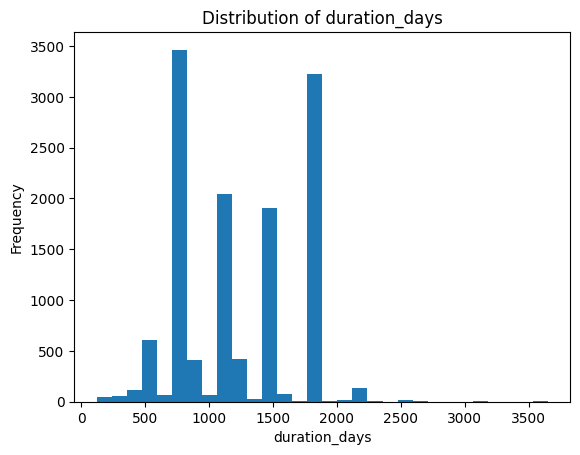

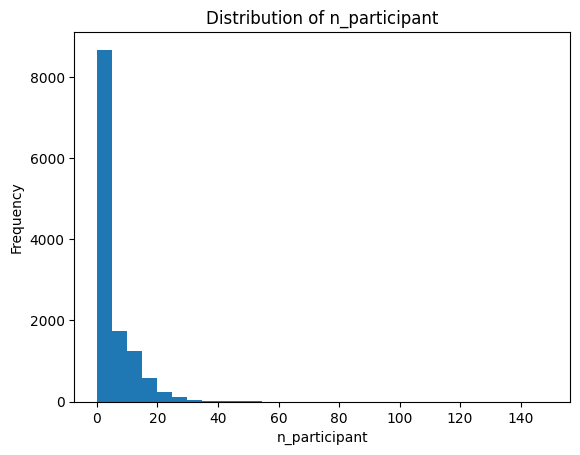

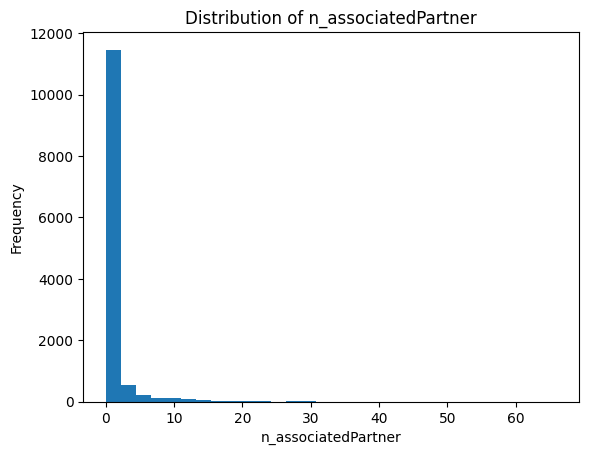

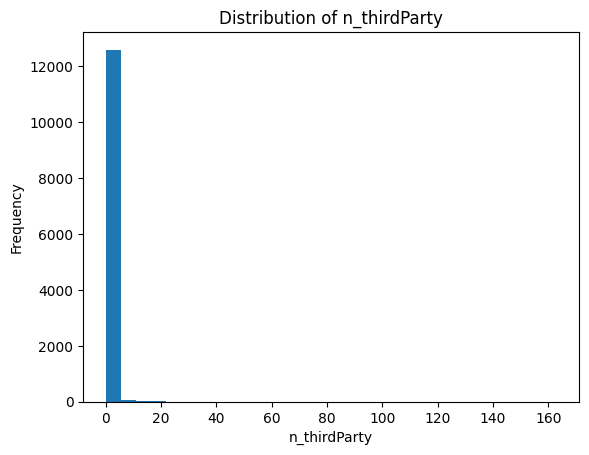

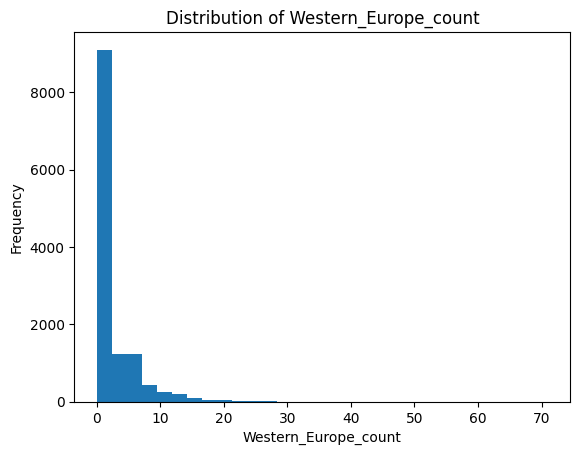

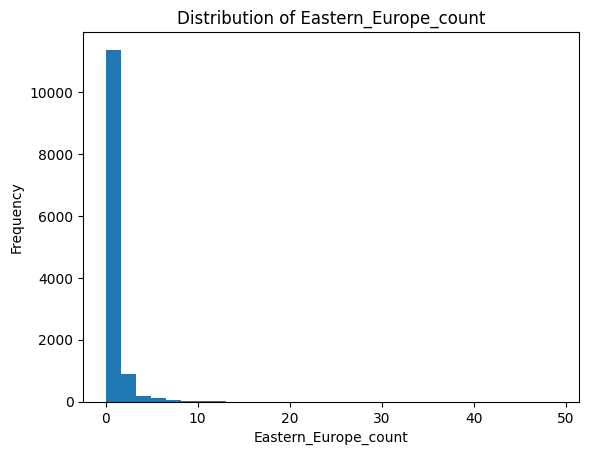

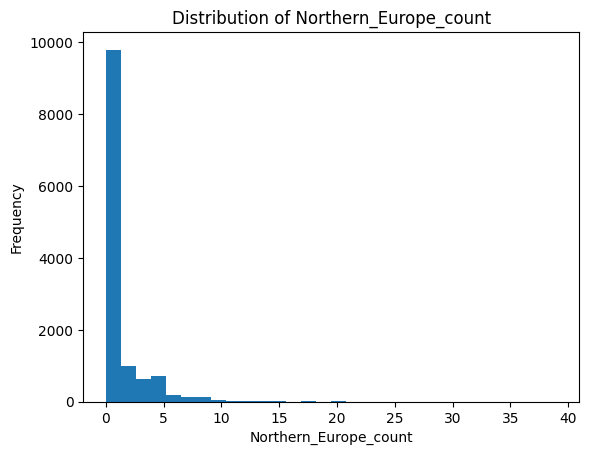

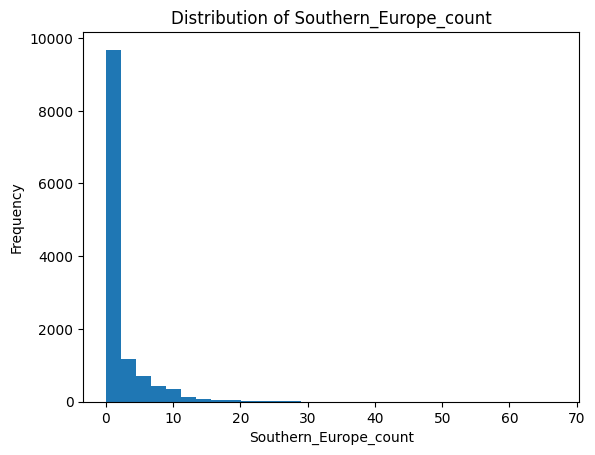

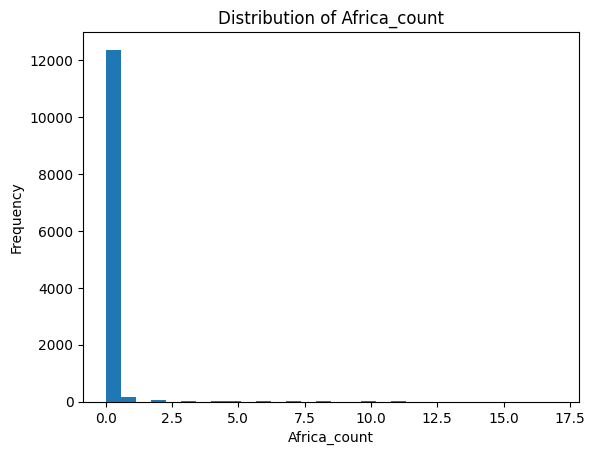

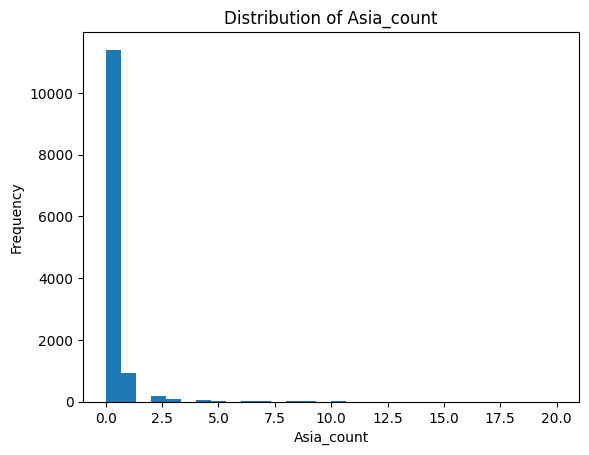

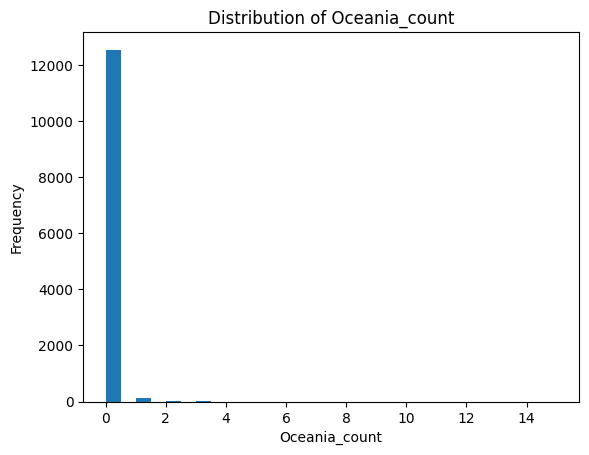

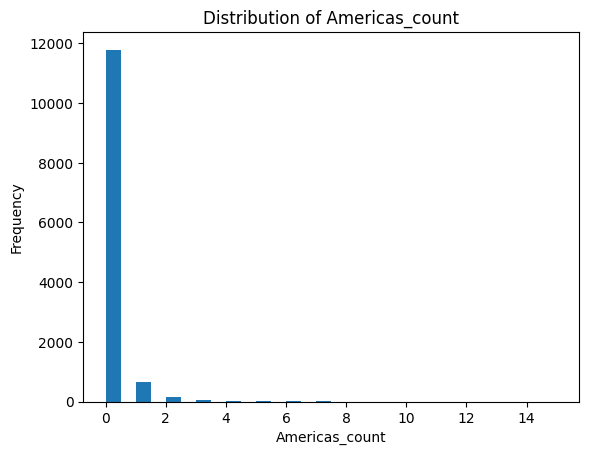

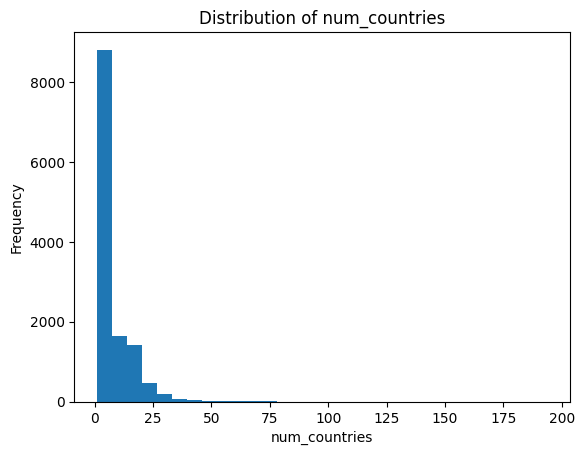

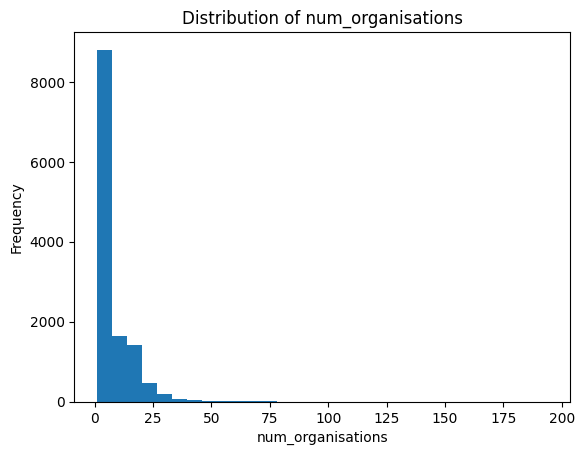

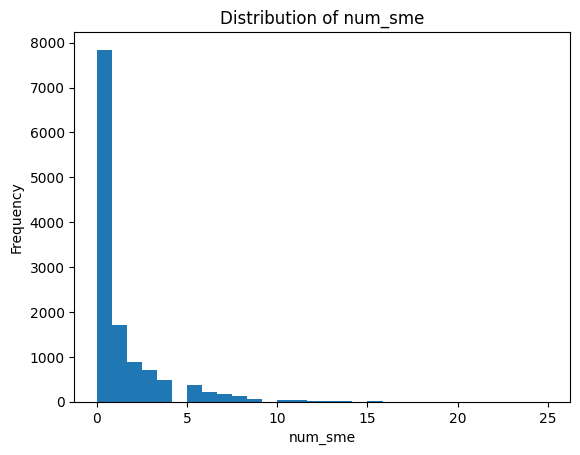

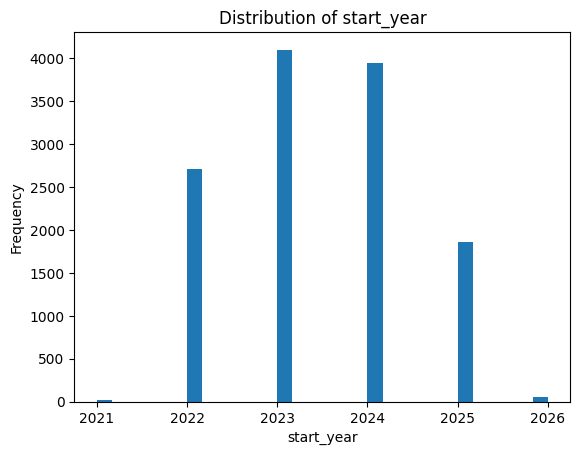

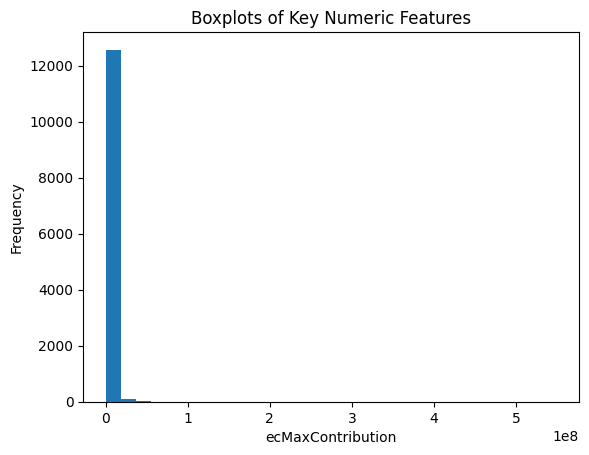

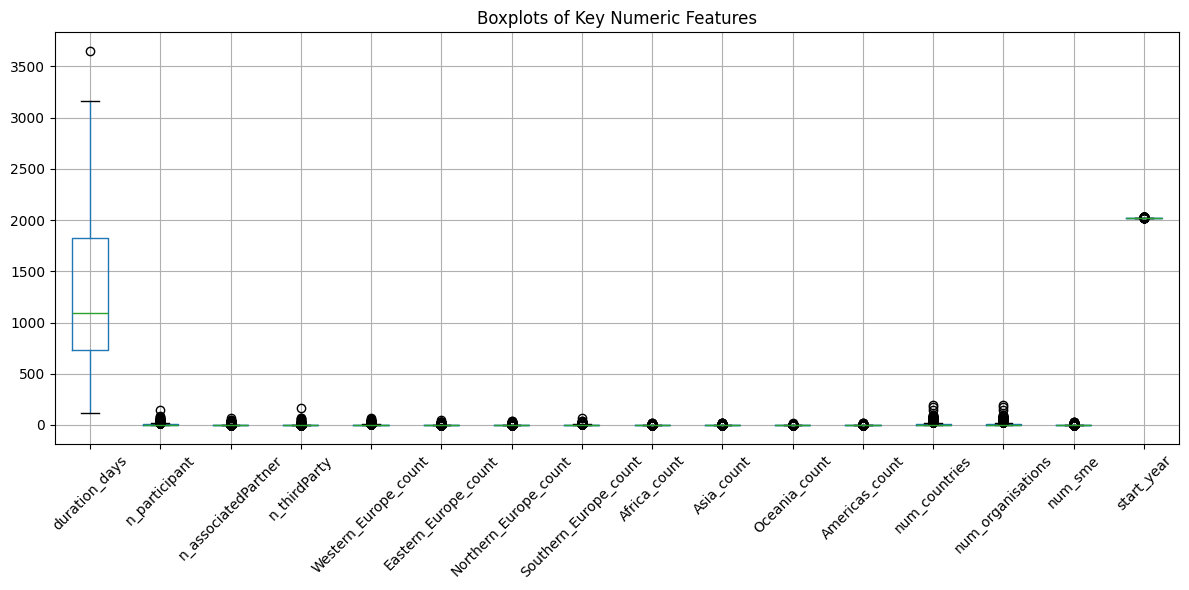

In [10]:
# 5) Short exploration of numerical variables (distribution and boxplots)
numeric_cols = ['duration_days','n_participant','n_associatedPartner',
    'n_thirdParty', 'Western_Europe_count', 'Eastern_Europe_count', 'Northern_Europe_count',
    'Southern_Europe_count', 'Africa_count', 'Asia_count', 'Oceania_count', 'Americas_count',
    'num_countries', 'num_organisations', 'num_sme', 'start_year']

for col in numeric_cols:
    plt.figure()
    plt.hist(X_train[col].dropna(), bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

plt.figure
plt.hist(X_train['ecMaxContribution'].dropna(),bins=30)
plt.title("Boxplots of Key Numeric Features")
plt.xlabel("ecMaxContribution")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12,6))
X_train[numeric_cols].boxplot(rot=45)
plt.title("Boxplots of Key Numeric Features")
plt.tight_layout()
plt.show()

In [11]:
# 6) Preprocess numerical and categorical features
# Custom target-transformer: winsorize at 1st/99th percentile, then log1p

class WinsorLogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lower=0.01, upper=0.99):
        self.lower = lower
        self.upper = upper

    def fit(self, y, X=None):
        y = np.array(y).ravel()
        self._clip_lo, self._clip_hi = np.quantile(y, [self.lower, self.upper])
        return self

    def transform(self, y):
        y = np.array(y).ravel()
        y = np.clip(y, self._clip_lo, self._clip_hi)
        return np.log1p(y).reshape(-1, 1)

    def inverse_transform(self, y):
        return np.expm1(y)

target_transformer = WinsorLogTransformer(lower=0.01, upper=0.99)

# Cyclical encoder for month
class CyclicalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, col, period):
        self.col = col
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        vals = X[self.col].astype(float).values
        sin = np.sin(2 * np.pi * vals / self.period)
        cos = np.cos(2 * np.pi * vals / self.period)
        return np.vstack([sin, cos]).T


month_encoder = Pipeline([
    ('cycle', CyclicalEncoder(col='start_month', period=12)),
    ('scale', StandardScaler()),
])

# numeric & categorical pipelines
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale',  StandardScaler()),
])

cat_cols = ['fundingScheme', 'masterCall', 'euroSciVoxTopic']
cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='__MISSING__')),
    ('encode', OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1
    )),
])

# Put it all together in a FeatureUnion
preprocessor = FeatureUnion([
    ('numeric',      ColumnTransformer([('num', num_pipe, numeric_cols)], remainder='drop')),
    ('categorical',  ColumnTransformer([('cat', cat_pipe, cat_cols)], remainder='drop')),
    ('month_cycle',  month_encoder),
    ('topic_enc',    topic_encoder),
    ('org_avg_ec',   Pipeline([('enc', org_encoder), ('scale', StandardScaler())])),
],
n_jobs=1
)


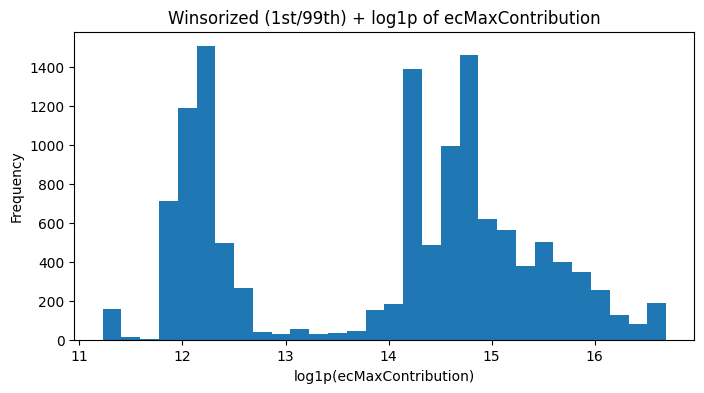

In [12]:
import matplotlib.pyplot as plt

# check distribution of target after transformation and winsorization
y_wl = target_transformer.fit_transform(y_train).ravel()
plt.figure(figsize=(8,4))
plt.hist(y_wl, bins=30)
plt.title('Winsorized (1st/99th) + log1p of ecMaxContribution')
plt.xlabel('log1p(ecMaxContribution)')
plt.ylabel('Frequency')
plt.show()

We have 2 peaks (one around 12 and one around 14-17), suggesting two very different populations. We thus build first a classifier (large vs small grand) and after that train two seperate regressors, one for each segment.

In [13]:
# 7) Compute features
with parallel_backend('threading'):
    X_train_feat = preprocessor.fit_transform(X_train, y_train)
    X_test_feat  = preprocessor.transform(X_test)


In [14]:
from sklearn.ensemble           import RandomForestClassifier
from sklearn.base               import BaseEstimator, RegressorMixin
from sklearn.compose            import TransformedTargetRegressor
from xgboost                    import XGBRegressor
import numpy as np

# 8a) Classification random forest

# binaray classification problem, define threshold to split small vs large
y_train_log = target_transformer.fit_transform(y_train).ravel()
threshold = 13.0
is_large = (y_train_log > threshold).astype(int)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_feat, is_large)

# labels for test set
y_test_log   = target_transformer.transform(y_test).ravel()
is_large_test = (y_test_log > threshold).astype(int)

# predictions
pred_labels = clf.predict(X_test_feat)

# accuracy
acc = accuracy_score(is_large_test, pred_labels)
print(f"Classifier accuracy on test split: {acc:.3f}")

print("\nClassification report:")
print(classification_report(is_large_test, pred_labels, target_names=['small','large']))

print("\nConfusion matrix:")
print(confusion_matrix(is_large_test, pred_labels))

Classifier accuracy on test split: 0.994

Classification report:
              precision    recall  f1-score   support

       small       0.99      0.99      0.99      1079
       large       1.00      1.00      1.00      2094

    accuracy                           0.99      3173
   macro avg       0.99      0.99      0.99      3173
weighted avg       0.99      0.99      0.99      3173


Confusion matrix:
[[1069   10]
 [   9 2085]]


In [15]:
from sklearn.svm import SVC

# 8b) Alternative classifier: SVM

# RBF SVM
svm_clf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',       # 'scale' is a good default
    probability=False,   # set True if you need .predict_proba()
    random_state=42
)

# fit
svm_clf.fit(X_train_feat, is_large)

# predict & evaluate
pred_labels_svm = svm_clf.predict(X_test_feat)

acc_svm = accuracy_score(is_large_test, pred_labels_svm)
print(f"SVM classifier accuracy on test split: {acc_svm:.3f}\n")

print("Classification report:")
print(classification_report(is_large_test, pred_labels_svm,
                            target_names=['small','large']))

print("Confusion matrix:")
print(confusion_matrix(is_large_test, pred_labels_svm))

SVM classifier accuracy on test split: 0.660

Classification report:
              precision    recall  f1-score   support

       small       0.00      0.00      0.00      1079
       large       0.66      1.00      0.80      2094

    accuracy                           0.66      3173
   macro avg       0.33      0.50      0.40      3173
weighted avg       0.44      0.66      0.52      3173

Confusion matrix:
[[   0 1079]
 [   0 2094]]


c:\Users\pappi\OneDrive\Bureaublad\Lessen\Modern Data Analytics\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pappi\OneDrive\Bureaublad\Lessen\Modern Data Analytics\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pappi\OneDrive\Bureaublad\Lessen\Modern Data Analytics\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

In [16]:
from sklearn.ensemble        import RandomForestClassifier, RandomForestRegressor
from sklearn.compose         import TransformedTargetRegressor
from sklearn.preprocessing   import FunctionTransformer
from sklearn.metrics         import r2_score, mean_absolute_error

# 9) Regressor
# small‐grant expert with log1p only —
log1p = FunctionTransformer(np.log1p, inverse_func=np.expm1)
small_rf_log = TransformedTargetRegressor(
    regressor=RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    transformer=log1p
)
mask_small_train = (is_large == 0)
small_rf_log.fit(
    X_train_feat[mask_small_train],
    y_train[mask_small_train]
)

# large‐grant expert on raw target
large_rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
mask_large_train = (is_large == 1)
large_rf.fit(
    X_train_feat[mask_large_train],
    y_train[mask_large_train]
)

# hierarchical predictions on TEST set
labels_test      = clf.predict(X_test_feat)
mask_small_test  = (is_large_test == 0)
mask_large_test  = (is_large_test == 1)

y_pred = np.empty(len(y_test), dtype=float)

y_pred[mask_small_test] = small_rf_log.predict(X_test_feat[mask_small_test])
y_pred[mask_large_test] = large_rf.predict(X_test_feat[mask_large_test])

# evaluation
print("Overall hierarchical R²:",   r2_score(y_test, y_pred))
print("Overall hierarchical MAE:", mean_absolute_error(y_test, y_pred))

print("\nSmall‐grant slice R²:",
      r2_score(y_test[mask_small_test], y_pred[mask_small_test]))
print("Small‐grant slice MAE:",
      mean_absolute_error(y_test[mask_small_test], y_pred[mask_small_test]))

print("\nLarge‐grant slice R²:",
      r2_score(y_test[mask_large_test], y_pred[mask_large_test]))
print("Large‐grant slice MAE:",
      mean_absolute_error(y_test[mask_large_test], y_pred[mask_large_test]))


Overall hierarchical R²: 0.7242862220284559
Overall hierarchical MAE: 699991.7635984753

Small‐grant slice R²: 0.8202995481530595
Small‐grant slice MAE: 10735.295547103027

Large‐grant slice R²: 0.6935937012013037
Large‐grant slice MAE: 1055153.0477567513


In [17]:

import pickle

# Save individual models
with open('small_grant_model.pkl', 'wb') as f:
    pickle.dump(small_rf_log, f)

with open('large_grant_model.pkl', 'wb') as f:
    pickle.dump(large_rf, f)

with open('classifier_model.pkl', 'wb') as f:
    pickle.dump(clf, f)

# %%
class HierarchicalGrantModel:
    def __init__(self, classifier, small_model, large_model):
        self.classifier = classifier
        self.small_model = small_model
        self.large_model = large_model
    
    def predict(self, X):
        # Classify small vs large
        is_large_pred = self.classifier.predict(X)
        
        # Initialize predictions array
        y_pred = np.empty(len(X), dtype=float)
        
        # Get masks
        mask_small = (is_large_pred == 0)
        mask_large = (is_large_pred == 1)
        
        # Make predictions
        if np.any(mask_small):
            y_pred[mask_small] = self.small_model.predict(X[mask_small])
        if np.any(mask_large):
            y_pred[mask_large] = self.large_model.predict(X[mask_large])
            
        return y_pred

# Create the hierarchical model
hierarchical_model = HierarchicalGrantModel(clf, small_rf_log, large_rf)

# Save it
with open('hierarchical_grant_model.pkl', 'wb') as f:
    pickle.dump(hierarchical_model, f)

# %%
# Load the hierarchical model
with open('hierarchical_grant_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)


